In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import random
random.seed(10)
import pycountry
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from keras import regularizers
from tensorflow.keras import metrics
import category_encoders as ce
from scipy import stats


## Load Data

In [3]:
dfolder = '../data/'

In [4]:
df_final = pd.read_csv(dfolder + 'preprocessed_df_old.csv')

In [5]:
df_final['deaths_all_pc']

0        6.492918
1        2.176669
2        0.000000
3        0.000000
4        0.000000
           ...   
79870    0.000000
79871    0.000000
79872    0.000000
79873    0.000000
79874    0.000000
Name: deaths_all_pc, Length: 79875, dtype: float64

## Preprocessing

In [6]:
df_final['country'] = df_final['Country Name']

In [7]:
armedconfdf = df_final.drop(columns=['Country Name'])

Here i'm taking the top 10 countries for model interpretability later.

In [8]:
top_10_countries=pd.DataFrame(armedconfdf.groupby('country')['deaths_all_pc'].sum()).sort_values(by='deaths_all_pc',ascending=False).reset_index()
top_10_country_names=top_10_countries.country[:11]

In [9]:
df_final.country.nunique()

195

In [10]:
df_final.drop(['MonthYear', 'date', 'month_year', 'Country Name'], axis=1, inplace=True)

In [11]:
df_final['armedconf'] = df_final['armedconf'].astype(int)
df_final['civilwar'] = df_final['civilwar'].astype(int)
df_final = df_final[df_final['year'] >= 2000]

In [12]:
combined_vars = list(df_final.columns)

These are the variable lists for our combinations we will use later on.

In [13]:
historical_vars = ['country', 'isocode', 'year', 'month', 'deaths_all_pc', 'armedconf', 'past6', 'past12', 'past60', 'past120','armedconf_since', 'deaths','state_deaths', 'nonstate_deaths','onesided_deaths', 'civilian_deaths']

old_eventshare_names = ['event_share_{}'.format(i) for i in range(1, 21)]
new_eventshare_names = ['share_events_count_events_{}'.format(i) for i in range(1, 21)]

text_gdelt_shares = ['norm_total_events'] + new_eventshare_names
text_gdelt_stocks = ['event_share_{}_stock'.format(i) for i in range(1, 21)]
text_gdelt_admin1 = ['num_regions', 'Adm1_Max', 'Adm1_Mean', 'Adm1_Median']

text_gdelt_vars = text_gdelt_shares + text_gdelt_admin1 + text_gdelt_stocks + ['country', 'isocode', 'year', 'month', 'deaths_all_pc']

## Preprocessing

In [14]:
def train_test_split_year(data, year, target_variable):
    x_train = data[data.index.get_level_values('year') < year].drop(columns=[target_variable])
    y_train = data[data.index.get_level_values('year') < year][target_variable]
    x_test = data[data.index.get_level_values('year') >= year].drop(columns=[target_variable])
    y_test = data[data.index.get_level_values('year') >= year][target_variable]
    return x_train, x_test, y_train, y_test

def preprocess_data(df_final, variables, split_year, target_variable):
    # Copy the dataframe and set multi-index
    conf = df_final[variables].copy()
    conf['country'] = list(conf.country)
    conf = conf.set_index(['isocode', 'year', 'month'])

    # Split data for each country and append to lists
    X_train, X_test, Y_train, Y_test = [], [], [], []
    for country in conf['country'].unique():
        data = conf[conf['country'] == country]
        x_train, x_test, y_train, y_test = train_test_split_year(data, split_year, target_variable)
        X_train.append(x_train)
        X_test.append(x_test)
        Y_train.append(y_train)
        Y_test.append(y_test)

    # Concatenate train and test data from each country
    X_train = pd.concat(X_train)
    Y_train = pd.concat(Y_train)
    X_test = pd.concat(X_test)
    Y_test = pd.concat(Y_test)

    # Concatenate X and Y dataframes
    train = pd.concat([X_train, Y_train], axis=1)
    test = pd.concat([X_test, Y_test], axis=1)

    return train, test


## Normalizing

In [15]:
def normalize_data(train, test, target_variable):
    # Save indices and 'country' column
    train_index = train.index
    test_index = test.index
    train_country = train['country']
    test_country = test['country']
    train_target = train[target_variable]
    test_target = test[target_variable]

    # Initialize scaler
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Scale train and test data, excluding 'country' and target variable column
    scaled_train = scaler.fit_transform(train.drop(columns=['country', target_variable]))
    scaled_test = scaler.transform(test.drop(columns=['country', target_variable]))

    # Convert back to DataFrame and add columns and index back
    scaled_train = pd.DataFrame(data=scaled_train, columns=train.drop(columns=['country', target_variable]).columns, index=train_index)
    scaled_test = pd.DataFrame(data=scaled_test, columns=test.drop(columns=['country', target_variable]).columns, index=test_index)

    # Add 'country' column back
    scaled_train['country'] = train_country
    scaled_test['country'] = test_country

    # Log transform target variable and add it back
    scaled_train[target_variable] = np.log1p(train_target)
    scaled_test[target_variable] = np.log1p(test_target)

    return scaled_train, scaled_test


## Model

In [16]:
def series_to_supervised_text(data, group_by_level, target_column_index, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        group_by_level: The level name to group by (e.g. 'isocode').
        target_column_index: The index of the target column in data
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t)
    for i in range(n_in, -1, -1):
        shifted = df.drop(columns=df.columns[target_column_index]).groupby(level=group_by_level).shift(i)
        cols.append(shifted)
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars) if j != target_column_index]
    # forecast sequence (t+1)
    shifted_target = df.groupby(level=group_by_level)[df.columns[target_column_index]].shift(-n_out)
    cols.append(shifted_target)
    names += ['var%d(t+%d)' % (target_column_index+1, n_out)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [17]:
def series_to_supervised(data, group_by_level, target_column_index, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        group_by_level: The level name to group by (e.g. 'isocode').
        target_column_index: The index of the target column in data
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t)
    for i in range(n_in, -1, -1):
        shifted = df.groupby(level=group_by_level).shift(i)
        cols.append(shifted)
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t+1)
    shifted_target = df.groupby(level=group_by_level)[df.columns[target_column_index]].shift(-n_out)
    cols.append(shifted_target)
    names += ['var%d(t+%d)' % (target_column_index+1, n_out)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [18]:
def reshape_data(train, test, target, text=False):
    """
    Reshape 'train' and 'test' dataframes into a format suitable for supervised learning,
    splitting them into input features (X) and target labels (y), and reshaping input 
    features into a 3D format required by LSTM models in Keras.

    Arguments:
        train: Training dataframe, with the last column being the target column.
        test: Test dataframe, with the last column being the target column.
        data_type: String indicating type of data ('text' or 'other').

    Returns:
        x_train: Input features for training data, reshaped into 3D format.
        x_test: Input features for test data, reshaped into 3D format.
        y_train: Target labels for training data.
        y_test: Target labels for test data.
        reframed_train: Training data transformed into a supervised learning format.
        reframed_test: Test data transformed into a supervised learning format.
    """
    
    # get the index of the target column
    target_column_index_train = train.columns.tolist().index(target)
    target_column_index_test = test.columns.tolist().index(target)

    # Frame as supervised learning and drop all time t columns except the target
    if text == True:
        reframed_train = series_to_supervised_text(train, 'isocode', target_column_index_train, 1, 1)
        reframed_test = series_to_supervised_text(test, 'isocode', target_column_index_test, 1, 1)
    else:
        reframed_train = series_to_supervised(train, 'isocode', target_column_index_train, 1, 1)
        reframed_test = series_to_supervised(test, 'isocode', target_column_index_test, 1, 1)

    # split into train and test sets
    train_values = reframed_train.values
    test_values = reframed_test.values

    # split into input and outputs
    train_X, y_train = train_values[:, :-1], train_values[:, -1]
    test_X, y_test = test_values[:, :-1], test_values[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    return x_train, x_test, y_train, y_test, reframed_train, reframed_test


In [19]:
def prepare_data_for_model(scaled_train, scaled_test, target):
    # Define a helper function to prepare a dataframe
    def prepare_df(df, target_encoder=None):
        non_country_cols = [col for col in df.columns if col != 'country' and col != target]
        non_country_data = df[non_country_cols]
        
        if target_encoder is None:
            target_encoder = ce.TargetEncoder(smoothing=2.0)
            country_data = target_encoder.fit_transform(df['country'], df[target])
        else:
            country_data = target_encoder.transform(df['country'])
            
        df_data = pd.concat([non_country_data, country_data, df[[target]]], axis=1)
        
        # Ensure the target column is the last one
        cols = list(df_data.columns)
        cols.remove(target)
        df_data = df_data[cols + [target]]
        
        return df_data, target_encoder

    # Prepare train and test data
    train_data, encoder = prepare_df(scaled_train, None)
    test_data, _ = prepare_df(scaled_test, encoder)

    return train_data, test_data, encoder


In [20]:
def train_and_evaluate_model(x_train, x_test, y_train, y_test, model, target_name):
    # train the given model
    early_stop = EarlyStopping(monitor='loss', patience=3)
    history = model.fit(x_train, y_train, epochs=30, batch_size=50, verbose=1, shuffle=False, callbacks=[early_stop])

    # plot training history
    plt.plot(history.history['loss'], label='Loss')
    plt.legend()
    plt.show()

    # make predictions
    y_pred = model.predict(x_test)

    # apply inverse transformation to predictions
    y_pred = np.expm1(y_pred)
    y_test= np.expm1(y_test)

    # reshape y_pred and y_test to 2D arrays
    y_pred = y_pred.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # return a dictionary of results
    return {'model': model, 
            'target': target_name,
            'y_test': y_test, 
            'y_pred': y_pred, 
            'mse': mse, 
            'mae': mae, 
            'r2': r2}

## Pipeline 

In [21]:
def run_pipeline(target_variable, variables, split_year, text):
    
    if target_variable == 'deaths' and variables == text_gdelt_vars:
        variables.remove('deaths_all_pc')
        variables.append(target_variable)

    # preprocess data
    train, test = preprocess_data(df_final, variables, split_year, target_variable)
    
    # normalize 
    scaled_train, scaled_test = normalize_data(train, test, target_variable)
    
    # prepare data for lstm model
    train_data, test_data, encoder = prepare_data_for_model(scaled_train, scaled_test, target_variable)
    
    # reshape data
    x_train, x_test, y_train, y_test, reframed_train, reframed_test = reshape_data(train_data, test_data, target_variable, text)
    
    # define model 
    model =Sequential()
    model.add(LSTM(60, input_shape=(x_train.shape[1], x_train.shape[2]), kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))
    
    # train and evaluate model
    results = train_and_evaluate_model(x_train, x_test, y_train, y_test, model, target_variable)
    
    return results , encoder, reframed_train , reframed_test, scaled_test


Running our pipeline to fit everything.

In [22]:
all_results = []

Running pipeline for target variable: deaths_all_pc


2023-07-01 11:56:12.551742: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-01 11:56:12.551903: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/30


2023-07-01 11:56:13.070990: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-01 11:56:14.463756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 11:56:15.479973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 11:56:16.015155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


834/834 [==============================] - 16s 15ms/step - loss: 0.9612
Epoch 2/30
834/834 [==============================] - 11s 13ms/step - loss: 0.1231
Epoch 3/30
834/834 [==============================] - 13s 16ms/step - loss: 0.0448
Epoch 4/30
834/834 [==============================] - 14s 17ms/step - loss: 0.0348
Epoch 5/30
834/834 [==============================] - 12s 14ms/step - loss: 0.0305
Epoch 6/30
834/834 [==============================] - 12s 14ms/step - loss: 0.0279
Epoch 7/30
834/834 [==============================] - 13s 16ms/step - loss: 0.0262
Epoch 8/30
834/834 [==============================] - 15s 17ms/step - loss: 0.0250
Epoch 9/30
834/834 [==============================] - 13s 16ms/step - loss: 0.0241
Epoch 10/30
834/834 [==============================] - 15s 18ms/step - loss: 0.0233
Epoch 11/30
834/834 [==============================] - 14s 17ms/step - loss: 0.0227
Epoch 12/30
834/834 [==============================] - 16s 19ms/step - loss: 0.0222
Epoch 13/30


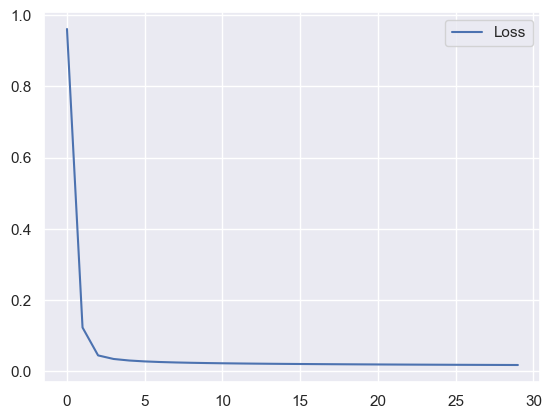

2023-07-01 12:02:31.720540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 12:02:31.842476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


384/384 [==============================] - 2s 5ms/step
Epoch 1/30


2023-07-01 12:02:36.013512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 12:02:36.290454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 12:02:36.468946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


834/834 [==============================] - 13s 14ms/step - loss: 0.6470
Epoch 2/30
834/834 [==============================] - 11s 14ms/step - loss: 0.1263
Epoch 3/30
834/834 [==============================] - 11s 13ms/step - loss: 0.0572
Epoch 4/30
834/834 [==============================] - 11s 13ms/step - loss: 0.0483
Epoch 5/30
834/834 [==============================] - 11s 14ms/step - loss: 0.0453
Epoch 6/30
834/834 [==============================] - 11s 13ms/step - loss: 0.0434
Epoch 7/30
834/834 [==============================] - 12s 14ms/step - loss: 0.0422
Epoch 8/30
834/834 [==============================] - 11s 13ms/step - loss: 0.0413
Epoch 9/30
834/834 [==============================] - 11s 14ms/step - loss: 0.0407
Epoch 10/30
834/834 [==============================] - 13s 15ms/step - loss: 0.0401
Epoch 11/30
834/834 [==============================] - 11s 13ms/step - loss: 0.0397
Epoch 12/30
834/834 [==============================] - 11s 13ms/step - loss: 0.0393
Epoch 13/30


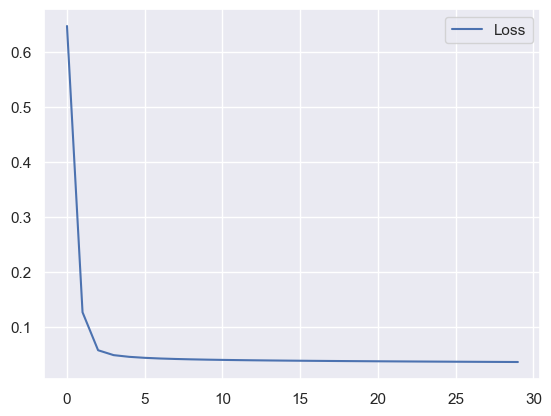

2023-07-01 12:08:13.050560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 12:08:13.157783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


384/384 [==============================] - 2s 4ms/step
Epoch 1/30


2023-07-01 12:08:17.526811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 12:08:17.861150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 12:08:18.039236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


834/834 [==============================] - 13s 13ms/step - loss: 0.2718
Epoch 2/30
834/834 [==============================] - 11s 13ms/step - loss: 0.0831
Epoch 3/30
834/834 [==============================] - 11s 13ms/step - loss: 0.0478
Epoch 4/30
834/834 [==============================] - 11s 13ms/step - loss: 0.0392
Epoch 5/30
834/834 [==============================] - 11s 14ms/step - loss: 0.0349
Epoch 6/30
834/834 [==============================] - 11s 13ms/step - loss: 0.0321
Epoch 7/30
834/834 [==============================] - 11s 13ms/step - loss: 0.0299
Epoch 8/30
834/834 [==============================] - 12s 14ms/step - loss: 0.0283
Epoch 9/30
834/834 [==============================] - 12s 14ms/step - loss: 0.0270
Epoch 10/30
834/834 [==============================] - 13s 16ms/step - loss: 0.0259
Epoch 11/30
834/834 [==============================] - 14s 16ms/step - loss: 0.0250
Epoch 12/30
834/834 [==============================] - 15s 18ms/step - loss: 0.0242
Epoch 13/30


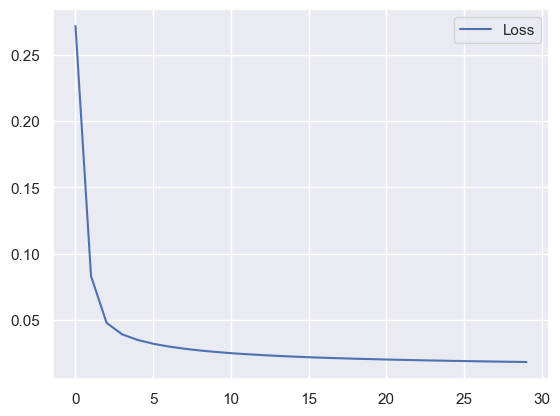

2023-07-01 12:14:34.612923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 12:14:34.728431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


384/384 [==============================] - 2s 4ms/step
Running pipeline for target variable: deaths
Epoch 1/30


2023-07-01 12:14:39.355729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 12:14:39.672895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 12:14:39.884402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


834/834 [==============================] - 13s 14ms/step - loss: 2.5214
Epoch 2/30
834/834 [==============================] - 12s 14ms/step - loss: 0.9145
Epoch 3/30
834/834 [==============================] - 12s 15ms/step - loss: 0.5918
Epoch 4/30
834/834 [==============================] - 12s 14ms/step - loss: 0.5026
Epoch 5/30
834/834 [==============================] - 11s 14ms/step - loss: 0.4603
Epoch 6/30
834/834 [==============================] - 12s 14ms/step - loss: 0.4354
Epoch 7/30
834/834 [==============================] - 12s 15ms/step - loss: 0.4194
Epoch 8/30
834/834 [==============================] - 12s 15ms/step - loss: 0.4084
Epoch 9/30
834/834 [==============================] - 12s 15ms/step - loss: 0.4006
Epoch 10/30
834/834 [==============================] - 12s 14ms/step - loss: 0.3949
Epoch 11/30
834/834 [==============================] - 12s 15ms/step - loss: 0.3905
Epoch 12/30
834/834 [==============================] - 12s 15ms/step - loss: 0.3870
Epoch 13/30


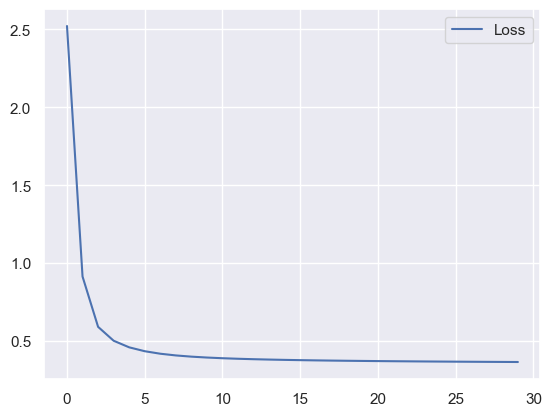

2023-07-01 12:20:49.730399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 12:20:50.033187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


384/384 [==============================] - 8s 16ms/step
Epoch 1/30


2023-07-01 12:20:59.598906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 12:21:00.067650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/834 [..............................] - ETA: 27:36 - loss: 21.7969

2023-07-01 12:21:00.292853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


834/834 [==============================] - 14s 14ms/step - loss: 2.5536
Epoch 2/30
834/834 [==============================] - 11s 13ms/step - loss: 1.6136
Epoch 3/30
834/834 [==============================] - 11s 13ms/step - loss: 1.1918
Epoch 4/30
834/834 [==============================] - 11s 13ms/step - loss: 0.9853
Epoch 5/30
834/834 [==============================] - 11s 14ms/step - loss: 0.8959
Epoch 6/30
834/834 [==============================] - 11s 13ms/step - loss: 0.8554
Epoch 7/30
834/834 [==============================] - 11s 13ms/step - loss: 0.8334
Epoch 8/30
834/834 [==============================] - 11s 13ms/step - loss: 0.8197
Epoch 9/30
834/834 [==============================] - 9s 10ms/step - loss: 0.8103
Epoch 10/30
834/834 [==============================] - 9s 11ms/step - loss: 0.8034
Epoch 11/30
834/834 [==============================] - 9s 11ms/step - loss: 0.7981
Epoch 12/30
834/834 [==============================] - 9s 11ms/step - loss: 0.7940
Epoch 13/30
834/

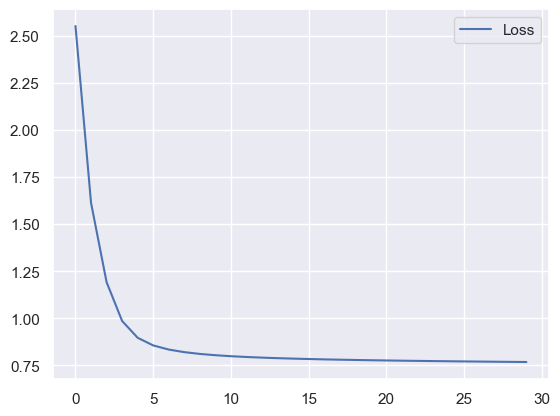

2023-07-01 12:25:46.316262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 12:25:46.409699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


384/384 [==============================] - 2s 4ms/step
Epoch 1/30


2023-07-01 12:25:50.974122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 12:25:51.247963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 12:25:51.426341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


834/834 [==============================] - 13s 13ms/step - loss: 1.9791
Epoch 2/30
834/834 [==============================] - 10s 13ms/step - loss: 0.9741
Epoch 3/30
834/834 [==============================] - 10s 12ms/step - loss: 0.5926
Epoch 4/30
834/834 [==============================] - 13s 15ms/step - loss: 0.4997
Epoch 5/30
834/834 [==============================] - 11s 13ms/step - loss: 0.4672
Epoch 6/30
834/834 [==============================] - 10s 12ms/step - loss: 0.4463
Epoch 7/30
834/834 [==============================] - 11s 13ms/step - loss: 0.4312
Epoch 8/30
834/834 [==============================] - 13s 15ms/step - loss: 0.4200
Epoch 9/30
834/834 [==============================] - 11s 14ms/step - loss: 0.4113
Epoch 10/30
834/834 [==============================] - 10s 12ms/step - loss: 0.4044
Epoch 11/30
834/834 [==============================] - 10s 11ms/step - loss: 0.3989
Epoch 12/30
834/834 [==============================] - 13s 15ms/step - loss: 0.3944
Epoch 13/30


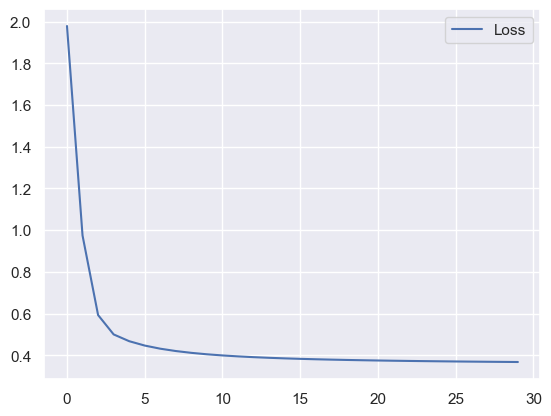

2023-07-01 12:31:31.495898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 12:31:31.597717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


384/384 [==============================] - 2s 3ms/step


In [23]:
target_variables = ['deaths_all_pc', 'deaths']

for target in target_variables:
    print(f"Running pipeline for target variable: {target}")
    
    result, encoder, reframed_train, reframed_test, sc_comb_test = run_pipeline(target, combined_vars, 2018, False)
    all_results.append({
        'target': target,
        'variables': 'combined_vars',
        'y_pred': result['y_pred'],
        'y_test': result['y_test'],
        'mse': result['mse'],
        'mae': result['mae'],
        'r2': result['r2'],
        'trained_model': result['model']
    })
    
    result, _, _, _, _ = run_pipeline(target, text_gdelt_vars, 2018, True)
    all_results.append({
        'target': target,
        'variables': 'text_gdelt_vars',
        'y_pred': result['y_pred'],
        'y_test': result['y_test'],
        'mse': result['mse'],
        'mae': result['mae'],
        'r2': result['r2'],
        'trained_model': result['model']
    })
    
    result, _, _, _, _ = run_pipeline(target, historical_vars, 2018, False)
    all_results.append({
        'target': target,
        'variables': 'historical_vars',
        'y_pred': result['y_pred'],
        'y_test': result['y_test'],
        'mse': result['mse'],
        'mae': result['mae'],
        'r2': result['r2'],
        'trained_model': result['model']
    })

In [24]:
reframed_train  

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  \
isocode year month                                                          
AFG     2000 2       0.008225    0.00000   0.000000   0.006193   0.013978   
             3       0.011881    0.00000   0.025308   0.025727   0.013978   
             4       0.040670    0.00115   0.016074   0.011196   0.013978   
             5       0.080731    0.00000   0.000000   0.047642   0.013978   
             6       0.007768    0.00000   0.010602   0.008576   0.013978   
...                       ...        ...        ...        ...        ...   
MDV     2017 7       0.000000    0.00000   0.000000   0.000000   0.000319   
             8       0.000000    0.00000   0.000000   0.000000   0.000319   
             9       0.000000    0.00000   0.000000   0.000000   0.000319   
             10      0.000000    0.00000   0.000000   0.000000   0.000319   
             11      0.000000    0.00000   0.000000   0.000000   0.000319   

                    var6(t-1)  var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  \
isocode year month                                                           
AFG     2000 2       0.001234   0.001357   0.002633   0.114855    0.045559   
             3       0.001602   0.001674   0.002202   0.120613    0.047774   
             4       0.000918   0.000717   0.002633   0.113742    0.044261   
             5       0.000928   0.001012   0.001511   0.109415    0.042748   
             6       0.001112   0.001157   0.003065   0.104459    0.044586   
...                       ...        ...        ...        ...         ...   
MDV     2017 7       0.001107   0.000792   0.000863   0.074691    0.030303   
             8       0.001017   0.001258   0.003324   0.090107    0.055272   
             9       0.000640   0.000867   0.001640   0.123156    0.065634   
             10      0.000746   0.000883   0.000863   0.119620    0.070253   
             11      0.000772   0.000896   0.001338   0.138311    0.062424   

                    ...  var96(t-0)  var97(t-0)  var98(t-0)  var99(t-0)  \
isocode year month  ...                                                   
AFG     2000 2      ...    0.145235    0.042462    0.000000    0.137339   
             3      ...    0.144932    0.042598    0.000000    0.120172   
             4      ...    0.143402    0.042759    0.000000    0.128755   
             5      ...    0.138684    0.042252    0.000000    0.133047   
             6      ...    0.133833    0.042286    0.000000    0.115880   
...                 ...         ...         ...         ...         ...   
MDV     2017 7      ...    0.000000    0.000000    0.939655    0.030043   
             8      ...    0.000000    0.000000    0.942529    0.030043   
             9      ...    0.000000    0.000000    0.945402    0.025751   
             10     ...    0.000000    0.000000    0.948276    0.030043   
             11     ...    0.000000    0.000000    0.951149    0.030043   

                    var100(t-0)  var101(t-0)   var102(t-0)  var103(t-0)  \
isocode year month                                                        
AFG     2000 2         0.267389     0.314349  3.270833e-01     5.808847   
             3         0.266662     0.311385  3.259144e-01     5.808847   
             4         0.267389     0.311343  3.221384e-01     5.808847   
             5         0.266662     0.309329  3.221722e-01     5.808847   
             6         0.267389     0.310948  3.247455e-01     5.808847   
...                         ...          ...           ...          ...   
MDV     2017 7         0.022287     0.007606  5.589177e-06     0.000000   
             8         0.000008     0.000003  8.572414e-14     0.000000   
             9         0.022976     0.006273  2.527524e-11     0.000000   
             10        0.023394     0.006500  2.527524e-11     0.000000   
             11        0.000000     0.000000  0.000000e+00     0.000000   

                    var104(t-0)  var104(t+1)  
isoc

In [35]:
test_data_copy = sc_comb_test.copy()
reframed_test

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  \
isocode year month                                                          
AFG     2018 2       0.267479   0.004985   0.002052   0.023583   0.026257   
             3       0.224981   0.000000   0.004788   0.008576   0.026257   
             4       0.212186   0.004601   0.012996   0.024774   0.026257   
             5       0.279513   0.005368   0.034200   0.045021   0.026257   
             6       0.374714   0.008052   0.006498   0.022153   0.026257   
...                       ...        ...        ...        ...        ...   
MDV     2022 12      0.000000   0.000000   0.000000   0.000000   0.000354   
        2023 1       0.000000   0.000000   0.000000   0.000000   0.000354   
             2       0.000000   0.000000   0.000000   0.000000   0.000354   
             3       0.000000   0.000000   0.000000   0.000000   0.000354   
             4       0.000000   0.000000   0.000000   0.000000   0.000354   

                    var6(t-1)  var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  \
isocode year month                                                           
AFG     2018 2       0.021673   0.029997   0.128470   0.144583    0.043972   
             3       0.015620   0.021228   0.097431   0.137939    0.048944   
             4       0.016625   0.023946   0.111850   0.142817    0.050789   
             5       0.015965   0.021742   0.111763   0.133035    0.040517   
             6       0.016386   0.022477   0.117634   0.140604    0.045618   
...                       ...        ...        ...        ...         ...   
MDV     2022 12      0.000471   0.000624   0.000389   0.152305    0.052104   
        2023 1       0.000426   0.000571   0.000259   0.108647    0.050998   
             2       0.000578   0.000861   0.000259   0.123366    0.040033   
             3       0.000201   0.000172   0.000043   0.126464    0.063232   
             4       0.000265   0.000262   0.000173   0.108541    0.028470   

                    ...  var96(t-0)  var97(t-0)  var98(t-0)  var99(t-0)  \
isocode year month  ...                                                   
AFG     2018 2      ...    0.163900    0.039246    0.000000    0.150215   
             3      ...    0.166136    0.039637    0.000000    0.150215   
             4      ...    0.169201    0.040146    0.000000    0.150215   
             5      ...    0.173478    0.040810    0.000000    0.150215   
             6      ...    0.175065    0.041180    0.000000    0.150215   
...                 ...         ...         ...         ...         ...   
MDV     2022 12     ...    0.000000    0.000000    1.126437    0.025751   
        2023 1      ...    0.000000    0.000000    1.129310    0.025751   
             2      ...    0.000000    0.000000    1.132184    0.017167   
             3      ...    0.000000    0.000000    1.135057    0.025751   
             4      ...    0.000000    0.000000    1.137931    0.025751   

                     var100(t-0)   var101(t-0)   var102(t-0)  var103(t-0)  \
isocode year month                                                          
AFG     2018 2      2.673888e-01  3.148136e-01  3.261698e-01     5.808847   
             3      2.673888e-01  3.148136e-01  3.261698e-01     5.808847   
             4      2.673888e-01  3.145600e-01  3.254576e-01     5.808847   
             5      2.673888e-01  3.145600e-01  3.254576e-01     5.808847   
             6      2.671386e-01  3.133410e-01  3.254576e-01     5.808847   
...                          ...           ...           ...          ...   
MDV     2022 12     1.195332e-13  8.155857e-14  8.515053e-14     0.000000   
        2023 1      2.228688e-02  7.605946e-03  5.589189e-06     0.000000   
             2      2.339360e-02  1.064467e-02  1.117835e-05     0.000000   
             3      2.228688e-02  1.520654e-02  1.587626e-02     0.000000   
             4      1.774053e-11  8.124052e-12  1.703011e-13     0.000000   

                    var10

In [26]:
df_results = pd.DataFrame(all_results)

In [27]:
all_results

[{'target': 'deaths_all_pc',
  'variables': 'combined_vars',
  'y_pred': array([[3.3742802],
         [3.1579936],
         [3.511238 ],
         ...,
         [0.       ],
         [0.       ],
         [0.       ]], dtype=float32),
  'y_test': array([[3.93329652],
         [5.3125398 ],
         [6.81444304],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]),
  'mse': 0.5773496062401308,
  'mae': 0.06641122419478258,
  'r2': 0.3270351322302918},
 {'target': 'deaths_all_pc',
  'variables': 'text_gdelt_vars',
  'y_pred': array([[0.8829164 ],
         [0.87168145],
         [0.8868412 ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]], dtype=float32),
  'y_test': array([[3.93329652],
         [5.3125398 ],
         [6.81444304],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]),
  'mse': 0.7894468676151494,
  'mae': 0.1002915062035322,
  'r2': 0.07981229893681774},
 {'target': 'deaths_

In [28]:
df_results

,target,variables,y_pred,y_test,mse,mae,r2
0,deaths_all_pc,combined_vars,"[[3.3742802], [3.1579936], [3.511238], [4.1954...","[[3.933296524437792], [5.312539796347371], [6....",0.577350,0.066411,0.327035
1,deaths_all_pc,text_gdelt_vars,"[[0.8829164], [0.87168145], [0.8868412], [0.90...","[[3.933296524437792], [5.312539796347371], [6....",0.789447,0.100292,0.079812
2,deaths_all_pc,historical_vars,"[[2.889508], [2.7065275], [3.0087898], [3.6182...","[[3.933296524437792], [5.312539796347371], [6....",0.590007,0.068959,0.312281
3,deaths,combined_vars,"[[1447.843], [1347.2092], [1509.5931], [1819.3...","[[1442.9999999999998], [1949.0000000000005], [...",104426.392620,21.566507,0.246478
4,deaths,text_gdelt_vars,"[[233.0305], [230.39244], [234.05933], [237.47...","[[1442.9999999999998], [1949.0000000000005], [...",135192.506460,34.327433,0.024476
5,deaths,historical_vars,"[[1287.6012], [1206.1061], [1343.5914], [1615....","[[1442.9999999999998], [1949.0000000000005], [...",105437.956298,21.897296,0.239179


In [29]:
# Initialize an empty DataFrame with the index from `reframed_test`
final_df = pd.DataFrame(index=reframed_test.index)

# Create true value columns
for target in set(result['target'] for result in all_results):
    true_values = next(result['y_test'].flatten() for result in all_results if result['target'] == target)
    final_df[f"{target}_true"] = true_values

# Create prediction value columns
for result in all_results:
    final_df[f"{result['target']}_{result['variables']}_pred"] = result['y_pred'].flatten()


In [30]:
final_df

deaths_true  deaths_all_pc_true  \
isocode year month                                    
AFG     2018 2           1443.0            3.933297   
             3           1949.0            5.312540   
             4           2500.0            6.814443   
             5           1737.0            4.734675   
             6           3176.0            8.657068   
...                         ...                 ...   
MDV     2022 12             0.0            0.000000   
        2023 1              0.0            0.000000   
             2              0.0            0.000000   
             3              0.0            0.000000   
             4              0.0            0.000000   

                    deaths_all_pc_combined_vars_pred  \
isocode year month                                     
AFG     2018 2                              3.374280   
             3                              3.157994   
             4                              3.511238   
             5                              4.195477   
             6                              3.941540   
...                                              ...   
MDV     2022 12                             0.000000   
        2023 1                              0.000000   
             2                              0.000000   
             3                              0.000000   
             4                              0.000000   

                    deaths_all_pc_text_gdelt_vars_pred  \
isocode year month                                       
AFG     2018 2                                0.882916   
             3                                0.871681   
             4                                0.886841   
             5                                0.901185   
             6                                0.892125   
...                                                ...   
MDV     2022 12                               0.000000   
        2023 1                                0.000000   
             2                                0.000000   
             3                                0.000000   
             4                                0.000000   

                    deaths_all_pc_historical_vars_pred  \
isocode year month                                       
AFG     2018 2                                2.889508   
             3                                2.706527   
             4                                3.008790   
             5                                3.618221   
             6                                3.405102   
...                                                ...   
MDV     2022 12                               0.000000   
        2023 1                                0.000000   
             2                                0.000000   
             3                                0.000000   
             4                                0.000000   

                    deaths_combined_vars_pred  deaths_text_gdelt_vars_pred  \
isocode year month                                                           
AFG     2018 2                    1447.843018                   233.030502   
             3                    1347.209229                   230.392441   
             4                    1509.593140                   234.059326   
             5                    1819.388916                   237.478897   
             6                    1698.973389                   235.090973   
...                                       ...                          ...   
MDV     2022 12                      0.000000                     0.000000   
        2023 1                       0.000000                     0.000000   
             2                       0.000000                     0.000000   
             3                       0.000000                     0.000000   
             4                       0.000000                     0.000000   

                    deaths_historical_vars_pred  


## Interpretation

In [49]:
# Sorting by year, month, and isocode
final_df_sorted = final_df.sort_index(level=['year', 'month', 'isocode'])

y_pred = final_df_sorted['deaths_all_pc_combined_vars_pred']
y_test = final_df_sorted['deaths_all_pc_true']

print(len(y_pred), len(y_test))  # check if lengths are now the same

# use the same index as in final_df_sorted
index = final_df_sorted.index
pa = pd.DataFrame(index=index)

pa['Prediction'] = y_pred
pa['Actual Values'] = y_test
pa.head()


12285 12285


,,,Prediction,Actual Values
isocode,year,month,,
AFG,2018,2,3.37428,3.933297
AGO,2018,2,0.00000,0.003198
ALB,2018,2,0.00000,0.000000
ARE,2018,2,0.00000,0.000000
ARG,2018,2,0.00000,0.000000


In [42]:
pa['Actual Values'].sum()

1226.2432771971514

RMSE:  0.7598352494061662


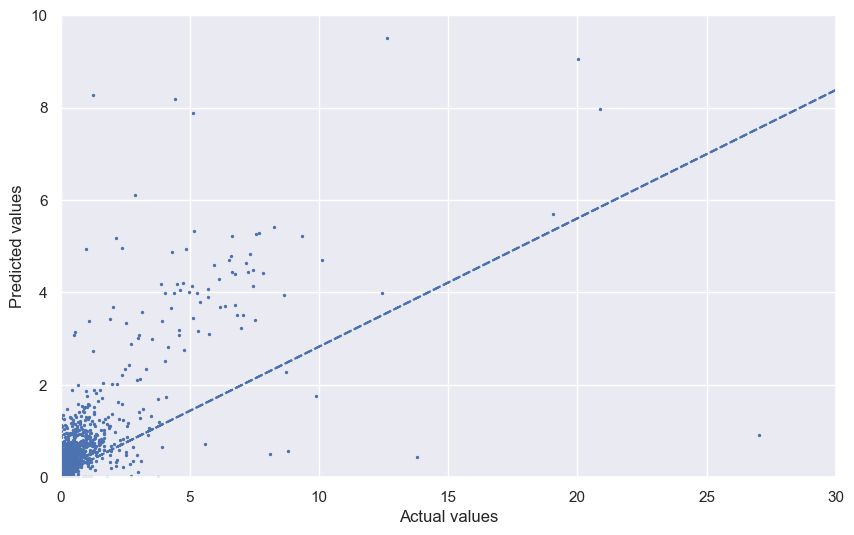

In [54]:
# Create DataFrame with y_test and y_pred
df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

# Sort df
df_sorted = df.sort_index(level=['isocode', 'year', 'month'])

# Extract sorted y_test and y_pred
y_test_sorted = df_sorted['y_test']
y_pred_sorted = df_sorted['y_pred']

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test_sorted, y_pred_sorted))
print('RMSE: ', rmse)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_sorted, y_pred_sorted, s=2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

# Set the limits of the x and y axes
plt.xlim([0, 30])  # adjust as necessary
plt.ylim([0, 10])  # adjust as necessary

# Fit a line to the predictions
z = np.polyfit(y_test_sorted, y_pred_sorted, 1)
p = np.poly1d(z)
plt.plot(y_test_sorted, p(y_test_sorted), "b--")
plt.show()


Metrics

In [56]:

mse = mean_squared_error(y_test_sorted, y_pred_sorted)
print('Mean Squared Error: ', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error: ', rmse)
mae = mean_absolute_error(y_test_sorted, y_pred_sorted)
print('Mean Absolute Error: ', mae)
r2 = r2_score(y_test_sorted, y_pred_sorted)
print('R-squared score: ', r2)


Mean Squared Error:  0.5773496062401308
Root Mean Squared Error:  0.7598352494061662
Mean Absolute Error:  0.06641122419478258
R-squared score:  0.3270351322302919


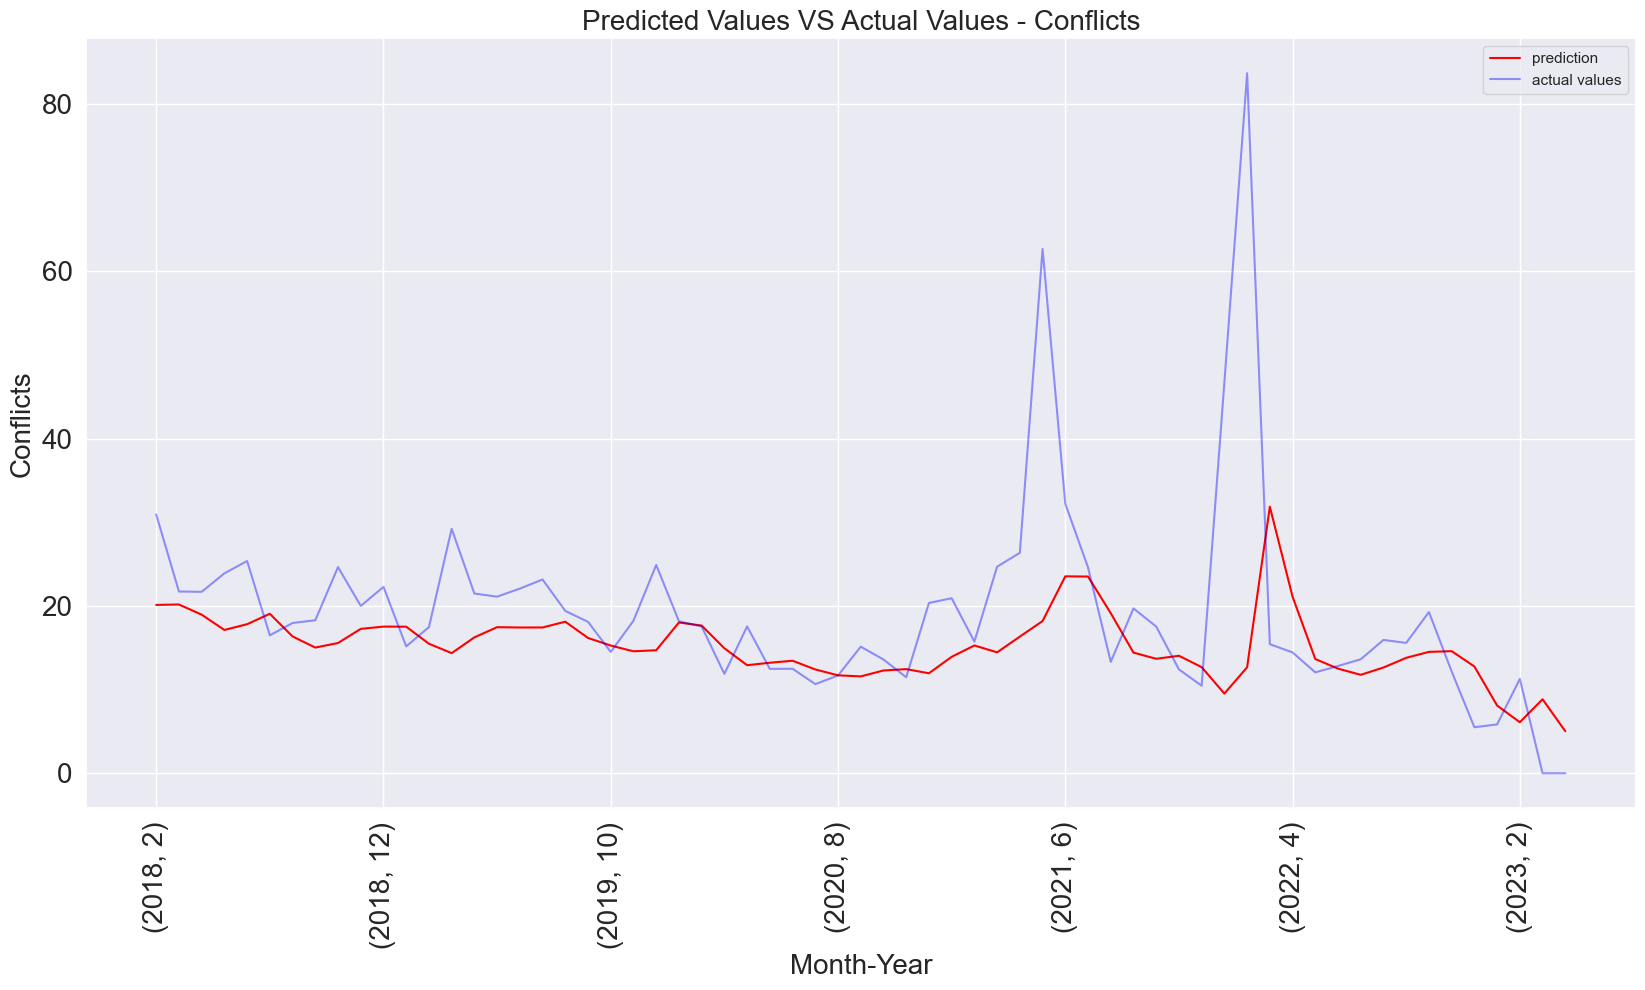

In [57]:
plt.figure(figsize=(20,10))
pa['Prediction'].groupby(level=['year', 'month']).sum().plot(kind='line', label='prediction', color='red', alpha=1)
pa['Actual Values'].groupby(level=['year', 'month']).sum().plot(kind='line', label='actual values', color='blue', alpha=0.4)

plt.xticks(rotation=90, size=20)
plt.yticks(size=20)

plt.ylabel('Conflicts', fontsize=20)
plt.xlabel('Month-Year', fontsize=20)
plt.title('Predicted Values VS Actual Values - Conflicts', fontsize=20)
plt.legend()


In [58]:
# this function is just to be able to predict and visualize a country subset of the data with our pre trained model

def reshape_test_data(test):
    target_column_index = test.shape[1] - 1
    # Frame as supervised learning and drop all time t columns except PM2.5
    reframed_test = series_to_supervised(test, 'isocode', target_column_index, 1, 1)
    # split into input and outputs
    test_values = reframed_test.values
    test_X, y_test = test_values[:, :-1], test_values[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_test, y_test

In [59]:
test_data_copy['deaths_all_pc']= test_data_copy.pop('deaths_all_pc')

/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_70989/1472141521.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data_copy['deaths_all_pc']= test_data_copy.pop('deaths_all_pc')


Let's predict using the same model but now for a subset of deadliest countries. 

In [60]:
def get_trained_model(target, variables):
    for result in all_results:
        if result['target'] == target and result['variables'] == variables:
            return result['trained_model']
    return None

# Usage
model = get_trained_model('deaths_all_pc', 'combined_vars')

if model is not None:
    print("Model found!")
    # Do something with the model here
else:
    print("No model found for this target and variables combination.")


KeyError: 'trained_model'

In [ ]:
for country_name in top_10_country_names:
    # test data for this country
    country_data = test_data_copy[test_data_copy['country'] == country_name].copy()  

    country_data['country'] = encoder.transform(country_data['country'])
    
    # Re-encode 'country' column
    
    x_test_country, test_labels = reshape_test_data(country_data)

    # generate predictions
    y_pred = model.predict(x_test_country)

    y_pred = np.expm1(y_pred)
    y_test= np.expm1(test_labels)

    # reshape y_pred and test_labels to 2D arrays
    y_pred = y_pred.reshape(-1, 1)
    test_labels = test_labels.reshape(-1, 1)
    
    # Print lengths
    print(f'Length of y_pred: {len(y_pred)}')
    print(f'Length of test_labels: {len(test_labels)}')

    # Print number of NaN values
    print(f'Number of NaN values in y_pred: {np.isnan(y_pred).sum()}')
    print(f'Number of NaN values in test_labels: {np.isnan(test_labels).sum()}')

    # shifting predictions
    y_hat_aligned = y_pred[1:]
    y_test_aligned = test_labels[:-1]

    # calculate errors
    mae = mean_absolute_error(y_test_aligned, y_hat_aligned)
    mse = mean_squared_error(y_test_aligned, y_hat_aligned)

    print('{} - Mean Absolute Error: {}, Mean Squared Error: {}'.format(country_name, mae, mse))

    # plot predicted vs actual
    pa = pd.DataFrame()
    pa['Date'] = pd.to_datetime(country_data.reset_index().year.astype(str) + '-' + country_data.reset_index().month.astype(str) + '-01')[-len(y_hat_aligned):]
    pa['Prediction'] = y_hat_aligned
    pa['Actual Values'] = y_test_aligned  # Flatten to get a 1D array for plotting

    plt.figure(figsize=(20, 10))
    plt.plot(pa['Date'], pa['Prediction'], label='prediction', color='red', alpha=1)
    plt.plot(pa['Date'], pa['Actual Values'], label='actual values', color='blue', alpha=0.4)
    plt.xticks(rotation=90, size=20)
    plt.yticks(size=20)

    plt.ylabel('Deaths', fontsize=20)
    plt.xlabel('Date', fontsize=20)
    plt.title('Predicted Values VS Actual Values - Deaths Per Capita in {}'.format(country_name), fontsize=20)
    plt.legend()
    plt.show()
